# **Computación Numérica**

## Aplicación de Métodos de Monte Carlo a la Computación Bayesiana

*Alumnos: Daniel Beteta Francisco, Javier Irigoyen Muñoz, Santiago Monteso Fernández.*

# Librerías utilizadas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform, binom, beta, kstest
import scipy.stats as st
from scipy.integrate import quad

from typing import Tuple, Dict

SEED = 123


# Introducción



En un *enfoque bayesiano* de la estadística, un parámetro $\theta$ se
considera una variable aleatoria con una determinada distribución de
probabilidad. El teorema de Bayes relaciona la información inicial que
se tiene del parámetro $\theta$ antes de realizar un experimento y la
información que se dispone después de realizar el experimento.

-   La información inicial que se tiene sobre $\theta$ se representa
    mediante su *distribución a priori* $\pi(\theta)$

-   La información que se tiene de $\theta$ después de realizar uno
    (o varios) experimento/s, $x$, se codifica mediante su
    *distribución a posteriori* $\pi(\theta | x)$.

-   El teorema de Bayes nos permite obtener la densidad de probabilidad
    $\pi(\theta | x)$ en función del resultado del experimento y la
    densidad de probabilidad a priori $\pi(\theta)$

$$
    \pi(\theta | x) = \frac{ \pi(x | \theta) } { \int_{-\infty}^{\infty} \pi(x | \theta) \pi(\theta) \; d\theta} \; \pi(\theta)
$$

-   La cantidad $\pi(x | \theta)$ del numerador se denomina
    *verosimilitud* (*likelihood*). Es una **función** y representa la
    probabilidad de observar el resultado del experimento $x$
    (muestra) en función del valor del parámetro $\theta$

    $$ \pi(x | \theta) = \prod_i f(x_i | \theta) $$

    siendo $x_i$ con $i=1, \ldots, n$ los resultados del
    experimento (valores muestrales) y $f(x_i | \theta)$ sus
    probabilidades para un determinado valor de $\theta$.

-   El denominador $\int_{-\infty}^{\infty} \pi(x | \theta)
    \pi(\theta) \; d\theta$, una vez realizada la integración,
    **no** depende del parámetro $\theta$. Es una constante de
    normalización.

-   Para realizar previsiones se utilizan *distribuciones predictivas*
    (valor esperado de una determinada función)

$$
    E[ g(y|x) ] = \int g(y| \theta) \; \pi(\theta | x)\; d\theta
$$

Por ejemplo, es habitual usar como *predictor* del valor de la v.a
    $\theta$ su valor esperado: $$ \widehat{\theta} = \int
    \theta \; \pi(\theta | x) \; d\theta $$

-   Cuando las distribuciones a priori y a posteriori son del mismo tipo
    se dice que son "conjugadas a priori". A menudo esto implica grandes
    beneficios desde el punto de vista computacional.


-   La descripción formal de la inferencia bayesiana es sencilla, sin
    embargo su implementación **habitualmente no es fácil** y requiere
    Métodos de Monte Carlo.

# Ejercicio 1

Estimar la probabilidad de que un paciente ingresado en planta acabe en la UCI. Para realizar este problema mediante inferencia Bayesiana debemos tener en cuenta: 

La probabilidad de que un paciente ingresado en planta acabe en la UCI será nuestro parámetro
$\theta$. Como hemos visto, en el enfoque bayesiano debemos
considerar que $\theta$ es una variable aleatoria.

Debemos conocer la distribución de la v.a $\theta$ antes de realizar el
experimento, es decir su densidad de probabilidad a priori
$\pi(\theta)$. Supongamos, por ejemplo, que $\pi(\theta) =
B(\theta | \alpha = 5, \beta = 10)$.

Debemos incorporar el resultado del experimento. Considerad el siguiente experimento: se contabiliza cuantos de los pacientes que hay en planta ($n$) deben ingresar en la UCI ($k$). Se observa que de los $n=20$ pacientes en
planta $k=1$ ingresan en la UCI.

Debemos calcular la función de verosimilitud $\pi(x | \theta)$ del resultado del experimento. La función de verosimilitud será proporcional a la probabilidad de observar el resultado del experimento en función del valor de $\theta$): $$ \pi(x | \theta) \propto \theta^k (1-\theta)^{n-k} $$ donde, en
este caso, habría que substituir $n=20$ y $k=1$. Notad como en la
ecuación anterior $\pi(x|\theta)$ no está normalizada.

Debemos elegir un predictor adecuado a nuestro problema. Como
predictor de $\theta$ la probabilidad de que un paciente de la
planta acabe en la UCI utilizaremos su valor esperado
$E[\theta]$. Nos preguntarnos entonces:

1. ¿Cuál es el valor de $E[\theta]$ antes de realizar el experimento? 

2. ¿Cuál es el valor de $E[\theta]$ después de observar el resultado del experimento?

Ayuda: La pregunta (1) es fácil. Al ser la distribución a priori $\pi(\theta)$ la distribución $Beta$, su valor esperado será
$$ 
\mu_{\text{prior}} = E[\theta]_{\text{prior}} = \int_{-\infty}^{\infty} \theta \; B(\theta | \alpha, \beta) \; d\theta = \frac{\alpha}{\alpha + \beta} 
$$

Para la pregunta (2) se debe calcular: 

$$ \mu_{\text{posterior}}= E[\theta]_{\text{posterior}} = \int_{-\infty}^{\infty} \theta \; \pi(\theta | x) \; d\theta 
$$

Para ello se necesita conocer la distribución a posteriori $\pi(\theta | x)$. Utilizando el teorema de Bayes, tras re-ordenar términos se obtiene:

\begin{align*} 
E[\theta]_{\text{posterior}} &=
\int_{-\infty}^{\infty} \theta \; \pi(\theta | x) \; d \theta 
= \int_{-\infty}^{\infty} \theta \; \frac{ \pi(x |
\theta) \; \pi(\theta) } { \int_{-\infty}^{\infty} \pi(x |
\theta) \pi(\theta) \; d \theta} \; d \theta 
    \\&= \frac{
\int_{-\infty}^{\infty} \theta \; \pi(x | \theta) \;
\pi(\theta) \; d \theta } { \int_{-\infty}^{\infty} \pi(x |
\theta) \; \pi(\theta) \; d \theta} 
= \frac{\int_{-\infty}^{\infty} \theta \; \theta^k
(1-\theta)^{n-k} \; \; \pi(\theta) \; d \theta } {
\int_{-\infty}^{\infty} \pi(x | \theta) \; \pi(\theta) \;
d \theta} \\ &= \frac{ \int_{0}^{1} \; \theta^{k+1} (1-\theta)^{n-k}
\; \; B(\theta | \alpha=5, \beta=10) \; d \theta } {
\int_{0}^{1} \theta^{k} (1-\theta)^{n-k} \; B(\theta | \alpha=5,
\beta=10) \; d \theta}
\end{align*} 

donde se han sustituído los
valores de $\pi(\theta)$ y de la verosimilitud $\pi(x | \theta)$. 

Si no supiésemos resolver analíticamente las integrales anteriores (en
este caso sí hay solución analítica aunque no es fácil) podemos
estimar el numerador y el denominador mediante integración de
Monte Carlo.


## **Solución analítica: aplicación teoría de Bayes:**

En el problema se sugiere utilizar una estrategia de Monte Carlo para
estimar el valor esperado de la distribución de probabilidad *a
posteriori* de $\theta$, siendo $\theta$ la probabilidad de que un
paciente en planta ingrese en la UCI.

En realidad, en este caso concreto, **no** es necesario utilizar Monte
Carlo. Cuando la distribución *a priori* $\pi(\theta)$ es una
distribución $Beta (\theta|\alpha, \beta)$ y la función de
verosimilitud $\pi(x| \theta)$ está dada por (5), la distribución
*a posteriori* $\pi(\theta| x)$ tiene una *expresión cerrada*. En
este caso $\pi(\theta| x)$ es también una distribución $Beta$ (se
dice que ambas son *conjugadas a priori*) de parámetros $\alpha'$ y
$\beta'$ donde $\alpha' = \alpha +k$ y $\beta'=\beta +
(n-k)$. Es decir, el parámetro $\alpha$ se incrementa en $k$ (el
número de éxitos del experimento) y $\beta$ en $n-k$ (el número de
fracasos).


**Respuesta:** Para resolver el problema es necesario aplicar Bayes. No obstante, la función de verosimilitud no es una función de densidad ya que, en general, su área no será la unidad. Por ello, es necesario normalizarla. Para ello, se calcula el valor de su integral entre 0 y 1 y ese será el valor de normalización.

$$\pi(x | \theta)=\theta^k (1-\theta)^{n-k}$$

El valor de la integral es:
$$\int_0^1 \pi(x|\theta) d\theta = \int_0^1 \theta^k (1-\theta)^{n-k}d\theta = \frac{k!(n-k)!}{n+1} = \frac{1}{(n+1)\binom{n}{k}}$$

Para que la integral sea la unidad, hay que multiplicar la integral original por el inverso de la anterior expresión:
$$(n+1)\binom{n}{k}\int_0^1 \theta^k (1-\theta)^{n-k} d\theta = (n+1)\int_0^1 \binom{n}{k}\theta^k (1-\theta)^{n-k} d\theta$$

Se observa que la última integral se corresponde con la distribución binomial, con lo cual la generación de los valores de la distribución de verosimilitud normalizada se pueden obtener multiplicando la Binomial por el factor de normalización (n+1).

In [ ]:
THETA_swept = np.arange(0, 1, 1e-3)
ALPHA = 5
_BETA = 10

def get_bayes_metrics(alpha: int, _beta: int,
                      amount_of_successes: int,
                      amount_of_patients: int) -> Tuple[float, float, float]:
    prior_probability = _get_prior_probability(alpha, _beta)
    posterior_probability = _get_posterior_probability(
        alpha, _beta, amount_of_successes, amount_of_patients
    )
    likelihood = _get_likelihood(amount_of_successes, amount_of_patients)
        
    print("Experimento: \n Total pacientes: {} \t UCI: {}".format(amount_of_successes, amount_of_patients))
    return prior_probability, posterior_probability, likelihood

def _get_prior_probability(alpha: int, _beta: int) -> float:
    prior_probability = beta(alpha, _beta).pdf(x=THETA_swept) 

    e_prior_probability = alpha / (alpha+_beta)
    print("Probabilidad a priori esperada: {}".format(e_prior_probability))
    return prior_probability


def _get_posterior_probability(alpha: int, _beta: int,
                               amount_of_successes: int,
                               amount_of_patients: int) -> float:
    posterior_probability = beta(
        alpha+amount_of_successes, 
        _beta + (amount_of_patients-amount_of_successes)
    ).pdf(x=THETA_swept)

    e_posterior_probability = (alpha+amount_of_successes)/(alpha+_beta+amount_of_patients)
    print("Probabilidad a posteriori esperada: {}".format(e_posterior_probability))
    return posterior_probability


def _get_likelihood(amount_of_successes: int,
                    amount_of_patients: int) -> float:
    likelihood = binom.pmf(
        k=amount_of_successes, 
        n=amount_of_patients, 
        p=THETA_swept
    )*(amount_of_patients+1)

    m_likelihood = np.argmax(likelihood)
    print("Maxima verosimilitud: {}".format(THETA_swept[m_likelihood]))
    return likelihood

In [ ]:
def plot_bayes(alpha: int, _beta: int,
               amount_of_successes: int,
               amount_of_patients: int) -> None:
    prior_probability, posterior_probability, likelihood = get_bayes_metrics(
        alpha, _beta, amount_of_successes, amount_of_patients
    )
    
    plt.figure(figsize=(15,8))
    plt.title('Probabilidad de ingreso en UCI (%d samples)' % amount_of_patients, fontsize=18)
    plt.plot(THETA_swept, prior_probability, linewidth=2, color='blue')
    plt.plot(THETA_swept, posterior_probability, linewidth=2, color='red')
    plt.plot(THETA_swept, likelihood, linewidth=2, color='green')
    plt.xlabel(r'$\theta$', fontsize=12)
    plt.ylabel('PDF', fontsize=12)
    plt.legend([r'prior, $\pi(\theta))$', r'posterior, $\pi(\theta|x))$', r'likelihood, $\pi(x|\theta))$'])
    plt.grid()
    plt.show()

En la gráfica siguiente se representan las distribuciones *a priori, a
posteriori* y *verosimilitud* para los valores propuestos por el
problema, $ \pi(\theta) = Beta(\theta|\alpha=5,\beta=10)$
$n=20$ y $k=1$.

Probabilidad a priori esperada: 0.3333333333333333
Probabilidad a posteriori esperada: 0.17142857142857143
Maxima verosimilitud: 0.05
Experimento: 
 Total pacientes: 1 	 UCI: 20


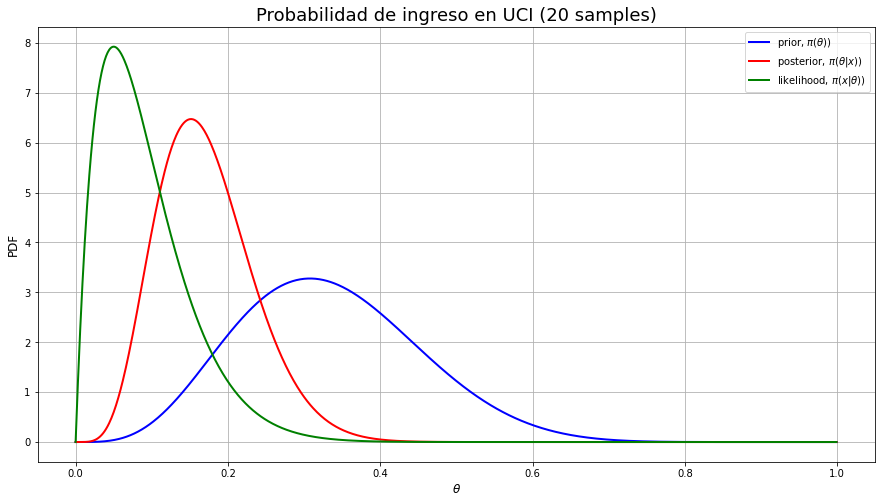

In [ ]:
amount_of_successes, amount_of_patients = 1, 20
plot_bayes(ALPHA, _BETA, amount_of_successes, amount_of_patients)

Como se observa la distribución a *posteriori* se sitúa entre la
distribución a priori (el conocimiento del que dispongo antes de
realizar el experimento) y la *verosimilitud* (el conocimiento que me
aporta *exclusivamente* el resultado del experimento).

En el problema estamos interesados en hallar el valor esperado de la v.a
\$\\theta\$ para las distribuciones *a priori* y *a posteriori*. O lo
que es lo mismo, debemos hallar el valor esperado de una v.a aleatoria
que se distribuye según una $Beta (\theta |\alpha, \beta)$ de
parámetros conocidos. Se puede demostrar que

$$
\mu = E[\theta] := \int_0^1 \theta \; B(\theta | \alpha,
\beta) \; d\theta = \frac{\alpha}{\alpha + \beta} 
$$

* **¿Qué ocurre cuando aumenta el tamaño del experimento?**

En la gráfica siguiente se ha incrementado la muestra del experimento,
$n=100$, pero manteniendo el ratio $\frac k n = 0.05$ del experimento
original

**Respuesta:** Cuando $n$ tiende a $\infty$ la función a posteriori tiende al valor de MLE y su forma se asemeja a una delta de Dirac centrada en dicho valor.

Probabilidad a priori esperada: 0.3333333333333333
Probabilidad a posteriori esperada: 0.08695652173913043
Maxima verosimilitud: 0.05
Experimento: 
 Total pacientes: 5 	 UCI: 100


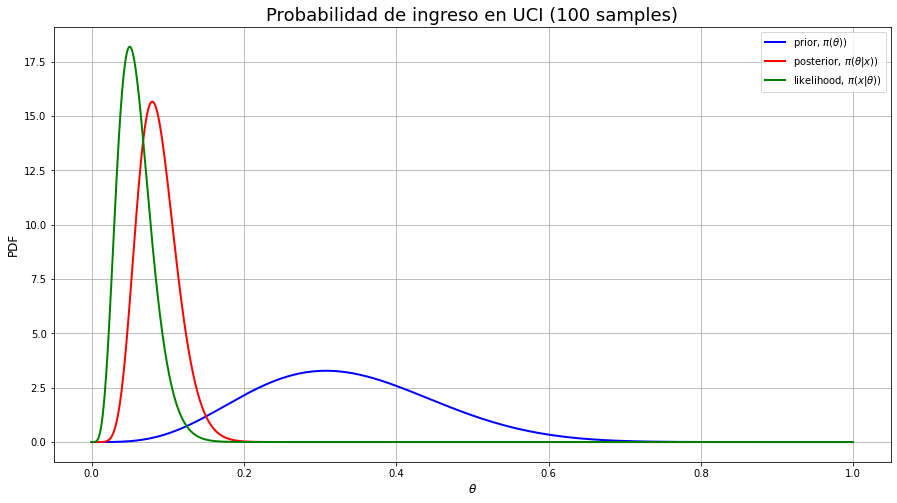

In [ ]:
amount_of_successes, amount_of_patients = 5, 100
plot_bayes(ALPHA, _BETA, amount_of_successes, amount_of_patients)

Algunas consecuencias interesantes a partir del conocimiento de la
expresión analítica de $\pi(\theta | x)$:

-   Al ser $\pi(\theta|x)$ también una distribución Beta, el valor esperado de $\theta$ a posteriori, i.e., después de observar el resultado del experimento, es:

$$
\mu_{posterior} = \frac{\alpha'}{\alpha' + \beta'} =
\frac{\alpha + k}{\alpha + k + \beta + n - k} 
$$

Comprobamos que $E[\theta]_{posterior} = \frac{ \int_{0}^{1} \; \theta^{k+1} (1-\theta)^{n-k}
\; \; B(\theta | \alpha=5, \beta=10) \; d \theta } {
\int_{0}^{1} \theta^{k} (1-\theta)^{n-k} \; B(\theta | \alpha=5,
\beta=10) \; d \theta} = \frac{(\alpha+k)}{(\alpha+\beta+n)}$:




In [ ]:
def function_to_be_integrated(theta: float, amount_of_successes: int, 
                              amount_of_patients: int, numerator: bool) -> np.ndarray:
    if numerator: 
        numerator_values = (
            (theta**(amount_of_successes+1))*(1-theta)**(amount_of_patients-amount_of_successes)
        )*beta(ALPHA, _BETA).pdf(x=theta)

        return numerator_values
    else: 
        denominator_values = (
            theta**amount_of_successes)*(1-theta)**(amount_of_patients-amount_of_successes
        )*beta(ALPHA, _BETA).pdf(x=theta)
        
        return denominator_values

In [ ]:
amount_of_successes = 1
amount_of_patients = 20

numerator = quad(
    function_to_be_integrated, 0, 1, 
    args=(amount_of_successes, amount_of_patients, True))[0]
denominator = quad(
    function_to_be_integrated, 0, 1, 
    args=(amount_of_successes, amount_of_patients, False))[0]

e_p1 = np.float32(numerator / denominator)
e_p2 = np.float32((ALPHA+amount_of_successes)/(ALPHA +_BETA + amount_of_patients))

print("¿Tienen el mismo valor (se muestra la diferencia en valor absoluto para no comparar en coma flotante)? {}".format(abs(e_p1 - e_p2)))

¿Tienen el mismo valor (se muestra la diferencia en valor absoluto para no comparar en coma flotante)? 0.0


Cuando el número de pacientes del experimento es muy grande, $n, k \to
\infty$, $\mu_{posterior}$ converge al valor de máxima
verosimilitud (MLE) $\frac k n$. Es decir, cuando $n \to \infty$, **el
*conocimiento a priori* es irrelevante frente a la información que
aporta el experimento.**

-   **La *incertidumbre* en torno al valor esperado $\mu_{posterior}$ decrece con $n \to \infty$**:

$$
\sigma^2 = \lim_{n \to \infty} \frac{ \alpha' \beta'}{
(\alpha' + \beta')^2 (\alpha' + \beta' +1) } = \frac{k n -k^2}{n^3}
= 0 
$$

$\textbf{Remark 1}$ El valor máximo de la verosimilitud MLE de una v.a
$\theta$ es el valor de $\theta$ para el cual la función de
verosimilitud es máxima: 
$$ 
\theta_{MLE} = \text{argmax}_{\theta} \pi(x | \theta)
$$ 

Habitualmente se calcula maximizando el logarítmo de $\pi(x|\theta)$:
$$
\frac{\partial}{\partial \theta} \log (\pi (x | \theta) ) = 0 
$$

Para este problema, en el que $\pi(x| \theta)$ está dada por la
ecuación (5): 
$$ 
\frac{\partial }{\partial \theta}\left( k \log
(\theta) + (n-k) \log(1-\theta) \right) = 0
$$

Se obtiene $\theta_{MLE} = \frac k n$

## **Simulación por Monte Carlo:**

<div class="qst2">
$\textbf{Remark 2: Propagación del error}$ Supongamos que $Z$ es el
cociente de dos v.a $Z = \frac X Y$, si estimamos el valor esperado de
$\mu_Z$ por ejemplo mediante 

$$
\widehat{\\mu\_z} = \frac{\sum_{i=1}^n x_i}{\sum_{i=1}^n y_i} 
$$

donde $\{x_0,x_1, \ldots, x_n \}$ y $\{y_0, y_1, \ldots, y_n \}$ son
muestras de $X$ e $Y$ respectivamente ¿cómo estimar la varianza de
$\widehat{\mu_z}$? Podemos interpretar $x$ e $y$ como una $\textit{medida con un error asociado}$ ($x\pm \delta x$, $x\pm \delta x$) y estimar el error de la medida de $z$ en el $\textit{peor caso}$

\begin{align*} 
    (z + \delta z) (y + \delta y) 
    &= x + \delta x \\ zy + z \delta y + y \, \delta z + \delta z \; \delta y 
    &= x + \delta x \\
\end{align*}

Si en la ecuación anterior se dividen los
dos miembros por \$x\$ y asumiendo el peor caso (los errores se
suman) 
$$ 
\frac{\delta z}{z} = \frac{\delta x}{x} +
\frac{\delta y}{y} 
$$
</div>

* **Respuesta:** Se debe estimar

$$\mu_{posterior} = \frac{ \int_{0}^{1} \; \theta^{k+1} (1-\theta)^{n-k}
\; \; B(\theta | \alpha=5, \beta=10) \; d \theta } {
\int_{0}^{1} \theta^{k} (1-\theta)^{n-k} \; B(\theta | \alpha=5,
\beta=10) \; d \theta}, $$ 

Para calcular la integral se usa el método de Monte Carlo generando muestras $\{\theta_0, \theta_1, \theta_2, \cdots, \theta_n\}$ de la distribución $\beta$ (prior) y evaluándolas en la función $\theta_i^{k+1}(1-\theta_i)^{n-k}$ para obtener un intervalo de confianza

$$[\widehat{\mu}_{posterior}\pm\mbox{Error}_{\mu_{posterior}}]$$

La expresióin del cociente queda

$$\widehat{\mu}_{posterior} = \frac{\widehat{I_1}}{\widehat{I_2}} = \frac{\sum{\theta_i^{k+1} (1-\theta_i)^{n-k}}}{\sum{\theta^{k} (1-\theta)^{n-k}}} = \frac{\sum{H_{num}({\theta_i})}}{\sum{H_{den}({\theta_i})}}$$

Usando la fórmula del enunciado para el cociente de estimadores queda

$$\mbox{Error}_{\mu_{posterior}} \, = \, \frac{\widehat{\mu}_{posterior} z_{\alpha / 2}}{
{\sqrt{n}}} \left(\frac{s_{I_1}}{\widehat{I_1}} + \frac{s_{I_2}}{\widehat{I_2}}\right)$$
con $s_{I_1}$ igual a

$$s_{I_1} = \sqrt{\frac{1}{n-1}\sum{(H_{num}(\theta_i)- \widehat{I_1}})^2}$$

y $s_{I_2}$ igual a

$$s_{I_2} = \sqrt{\frac{1}{n-1}\sum{(H_{den}(\theta_i)- \widehat{I_2})^2}},$$

El precentil es $z_{\alpha / 2}$ para el valor de $\alpha$ seleccionado.

* **¿Por que se debe utilizar la misma muestra de $\theta$ en el numerador y denominador para estimar $\mu_{posterior}$?**
      

Para que la normalización se haga correctamente debe hacerse sobre los mismos datos (misma $\theta$).

* **¿Por que a la hora de hacer la simulación de M.C hemos podido utilizar una función sin normalizar proporcional a $\pi(x |\theta)$ eq. (5) y no $\pi(x |\theta)$?**

Partiendo del resultado obtenido en apartados anteriores (la función de verosimilitud normalizada es proporcional a la Binomial por un factor [n+1]), al operar sobre la expresión:

$$E[\theta]_{\text{posterior}} =
\int_{-\infty}^{\infty} \theta \; \pi(\theta | x) \; d \theta  $$
$$= \int_{-\infty}^{\infty} \theta \; \frac{ \pi(x |
\theta) \; \pi(\theta) } { \int_{-\infty}^{\infty} \pi(x |\theta) \pi(\theta) \; d \theta} \; d \theta$$

se anula el denominador.

In [ ]:
def get_dict_info_a_posteriori(i1: np.ndarray, i2: np.ndarray, 
                               amount_of_patients: int, significance_level: float) -> Dict[str, float]: 
    size = _get_size(amount_of_patients)

    mean1, mean2 = _get_means(i1, i2, size)
    sample_mean = mean1/mean2

    sample_variance1, sample_variance2 = _get_sample_variance(
        i1, i2, size, mean1, mean2
    )
    
    error1, error2 = _get_errors(
        sample_variance1, sample_variance2,
        mean1, mean2
    )
    sample_error = sample_mean * (error1+error2)
      
    ci_inf, ci_sup = _get_ci_inf_and_sup(
        significance_level, size, sample_mean, sample_error
    )
    
    return {'size' : size, 'media' : sample_mean, 'ci_inf': ci_inf, 'ci_sup' : ci_sup}

def _get_size(amount_of_patients: int) -> np.ndarray:
    return np.arange(start=1, stop=amount_of_patients+1, step=1)


def _get_means(i1: np.ndarray, i2: np.ndarray, 
              size: np.ndarray) -> Tuple[float, float]:
    mean1 = np.cumsum(i1) / size
    mean2 = np.cumsum(i2) / size
    return mean1, mean2


def _get_sample_variance(i1: np.ndarray, i2: np.ndarray, size: np.ndarray,
                         mean1: float, mean2: float) -> Tuple[float, float]:
    s2_1, s2_2 = (i1-mean1)**2, (i2-mean2)**2
    s2_1[0], s2_2[0]  = 0., 0.
    s2_1[1:] = np.cumsum(s2_1)[1:]/size[0:-1]
    s2_2[1:] =np.cumsum(s2_2)[1:]/size[0:-1]
    return np.sqrt(s2_1), np.sqrt(s2_2)


def _get_errors(sample_variance1: float, sample_variance2: float,
                mean1: float, mean2: float) -> Tuple[float, float]:
    error1 = sample_variance1 / mean1
    error2 = sample_variance2 / mean2
    return error1, error2


def _get_ci_inf_and_sup(significance_level: float, size: np.ndarray, 
                        sample_mean: float, sample_error: float) -> Tuple[float, float]:
    z_alpha = norm.ppf(1 - (significance_level/2))
    error = z_alpha/np.sqrt(size)*sample_error
    ci_inf = sample_mean - error
    ci_sup = sample_mean + error
    return ci_inf, ci_sup

In [ ]:
def estimate_integrand(amount_of_successes: int, amount_of_patients: int, x: np.ndarray, p, numerator: bool):
    if numerator:
        return (x**(amount_of_successes+1))*((1-x)**(amount_of_patients-amount_of_successes))*p
    else:
        return (x**amount_of_successes)*((1-x)**(amount_of_patients-amount_of_successes))*p

Para definir los intervalos de confianza, por un lado se realiza una **simulación independiente y varios tamaños** (esperanzas y error para cada tamaño), por otro lado se llevan a cabo **simulaciones independientes con varios tamaños** (esperanzas diferentes para cada tamaño de muestra).

In [ ]:
def get_info_unique_simulation(alpha: int, _beta: int, 
                               amount_of_successes: int, 
                               amount_of_patients: int, 
                               max_sample_value: int, 
                               significance_level: float, 
                               generator_beta: bool) -> Dict[str, float]:
    """
    Calcula las estimaciones de la media y el error de E[θ] (posterior)
    """
    if generator_beta:
        # Distribución Beta
        sample = beta(ALPHA, _BETA).rvs(max_sample_value)
        p = 1
    else:
        # Distribución Uniforme
        sample = uniform.rvs(loc=0, scale=1, size=max_sample_value)
        p = beta(ALPHA, _BETA).pdf(x=sample)
    
    i1 = estimate_integrand(
        amount_of_successes, amount_of_patients, sample, p, True
    )
    i2 = estimate_integrand(
        amount_of_successes, amount_of_patients, sample, p, False
    )
    mean = np.sum(i1) / np.sum(i2)
    z_alpha = norm.ppf(1-(significance_level/2))
    error = mean*z_alpha/np.sqrt(max_sample_value)*(np.std(i1)/np.mean(i1)+np.std(i2)/np.mean(i2))

    print("Probabilidad a posteriori teórica esperada: {}".format((ALPHA+amount_of_successes)/(ALPHA+_BETA+amount_of_patients)))
    print("Probabilidad a posteriori esperada: {} +- {}".format(mean, error))
    print("Nivel de significancia estadística: {}".format(significance_level))
    print("Experimento: \n Total pacientes: {} \t UCI: {}".format(amount_of_patients, amount_of_successes))
    print("Tamaño máximo de la muestra = {}".format(max_sample_value))

    return get_dict_info_a_posteriori(i1=i1, i2=i2, amount_of_patients=max_sample_value, significance_level=significance_level)

In [ ]:
def get_info_several_simulations(alpha: int, _beta: int, 
                                 amount_of_successes: int, 
                                 amount_of_patients: int, 
                                 max_sample_value: int, 
                                 nsimul: int, 
                                 significance_level: float, 
                                 generator_beta: bool) -> np.ndarray:
    """
    Realiza nsimul simulaciones para calcular el intervalo de confianza para E[θ] (posterior)
    """
    r_all = np.zeros((max_sample_value, nsimul))

    if generator_beta:
        # Distribución Beta
        sample = beta(alpha, _beta).rvs(max_sample_value*nsimul).reshape((nsimul, max_sample_value))
        p = 1
    else:
        # Distribución Uniforme
        sample = uniform.rvs(
            loc=0, scale=1, size=max_sample_value*nsimul
        ).reshape((nsimul, max_sample_value))
        
    for simul in np.arange(nsimul):
        x = sample[simul,:]
        if not generator_beta:
            p = beta(alpha, _beta).pdf(x=x)
        i1 = estimate_integrand(amount_of_successes, amount_of_patients, x, p, True)
        i2 = estimate_integrand(amount_of_successes, amount_of_patients, x, p, False)
        r = get_dict_info_a_posteriori(
            i1, i2, max_sample_value, significance_level
        ) 
        r_all[:, simul] = r['media']
    
    return r_all

In [ ]:
def get_theorical_theta(amount_of_successes: int, amount_of_patients) -> float:
  return (ALPHA+amount_of_successes)/(ALPHA+_BETA+amount_of_patients)

In [ ]:
def plot_posteriori(r1: Dict[str, float], r_all: np.ndarray, 
                    max_sample_value: int, e_theoric_theta: float) -> None:
    fig, ax = plt.subplots(1,2, figsize=(20, 10), sharey=True)
    plt.ylim([-0.1, 0.3])

    ax[0].plot (r1['size'], r1['media'],  c='blue' ,linestyle='dotted', lw=0.8)
    ax[0].plot (r1['size'], r1['ci_inf'], c='blue', alpha=0.4, lw=0.2)
    ax[0].plot (r1['size'], r1['ci_sup'], c='blue', alpha=0.4, lw=0.2)
    ax[0].fill_between(r1['size'],r1['ci_inf'],r1['ci_sup'], alpha=0.2)

    ax[0].hlines(e_theoric_theta, 0, r1['size'][-1], colors='red', lw=0.8, linestyle ="--")
    ax[0].set_xlabel("Tamaño de la muestra")
    ax[0].set_ylabel (r'$\hat{\mu}_{posteriori}$')
    ax[0].grid(lw=0.2)

    xx = np.arange(1, max_sample_value+1)
    ax[1].hlines(e_theoric_theta, 0, xx[-1], colors='red', linewidth=1, linestyle ="--")
    ax[1].plot(xx, r_all, linewidth=0.2, alpha=0.4)
    ax[1].set_ylabel (r'$\hat{\mu}_{posteriori}$')
    ax[1].set_xlabel("Tamaño de la muestra")
    ax[1].grid(lw=0.2)

    plt.show()

In [ ]:
def plot_posteriori_where(max_sample_value: int, 
                          significance_level: float, 
                          generator_beta: bool) -> None:
  np.random.seed(SEED)
  amount_of_successes = 5 
  amount_of_patients = 100
  nsimul = 100 

  r1 = get_info_unique_simulation(
      ALPHA, _BETA, amount_of_successes, amount_of_patients, 
      max_sample_value, significance_level, generator_beta
  )
  r_all = get_info_several_simulations(
      ALPHA, _BETA, amount_of_successes, amount_of_patients, 
      max_sample_value, nsimul, significance_level, generator_beta
  )

  e_theoric_theta = get_theorical_theta(amount_of_successes, amount_of_patients)
  plot_posteriori(r1, r_all, max_sample_value, e_theoric_theta)

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08778662317655711 +- 0.021749430123477787
Nivel de significancia estadística: 0.22
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 6000


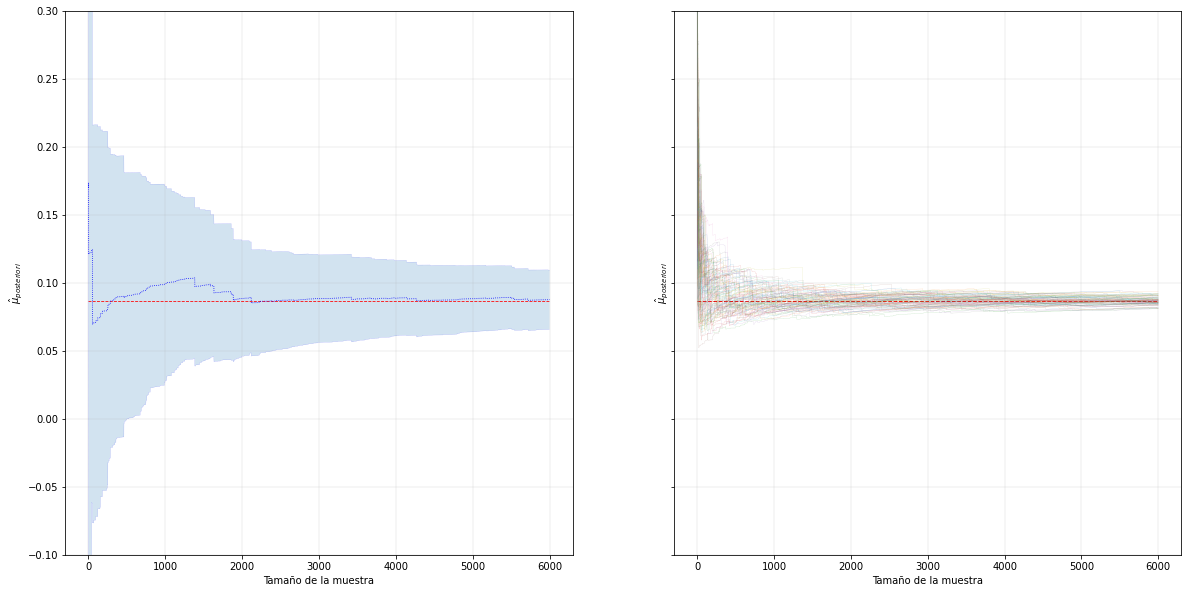

In [ ]:
plot_posteriori_where(max_sample_value=6000, significance_level=0.22, generator_beta=True)

* **¿Se comporta correctamente tu estimación cuando aumenta el tamaño del experimento?**

Para comprobarlo aumentamos el tamaño máximo de la muestra de 6000 a 60000:

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08727203667363007 +- 0.0068569063545529585
Nivel de significancia estadística: 0.22
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 60000


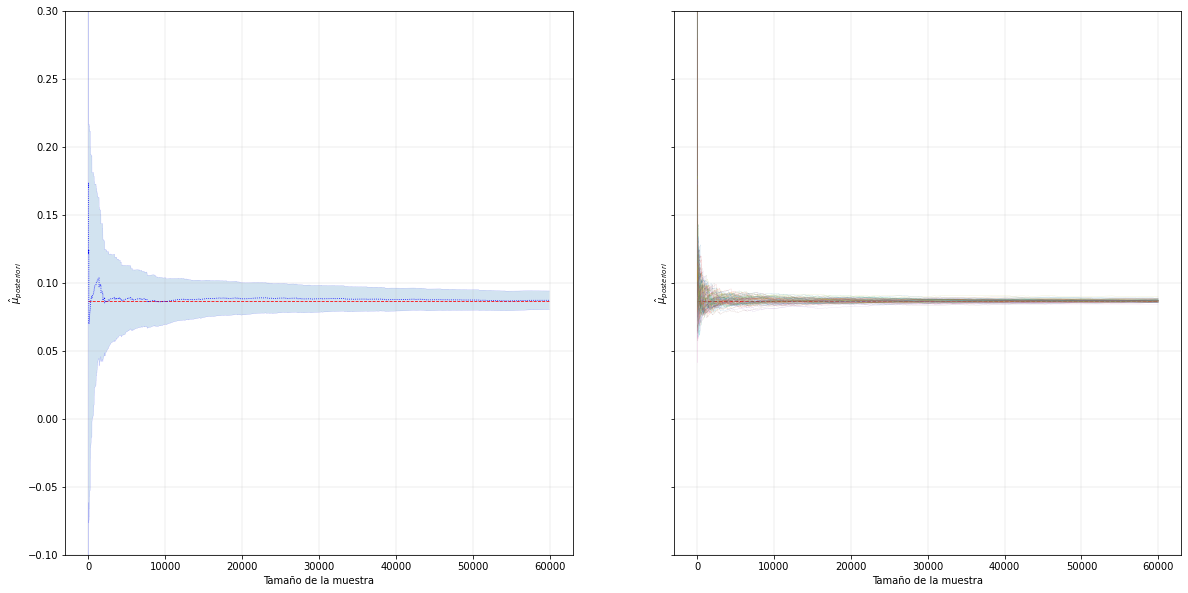

In [ ]:
plot_posteriori_where(max_sample_value=60000, significance_level=0.22, generator_beta=True)

De tal forma, para tamaños de muestra menores que 2000, el valor estimado $\widehat{\mu}_{posterior}$ se aleja más del teórico y presenta mayor varianza. Sin embargo, a partir de este tamaño muestral, apenas difiere respecto al valor teórico $\mu_{posterior}$ y disminuye considerablemente la varianza. 

Para un tamaño muestral igual a 6000 se obtiene un error estimado de 0.021749430123477787, mientras que para 60000 disminuye considerablemente a 0.02168344178286942.
            



-   **¿Cómo de fiable es la estimación del error que hemos hecho? Discute que valor de $z_{\alpha/2}$ es apropiado.**

Para aumentar la confianza en los resultados, tendríamos que utilizar un nivel de significación $\alpha$ igual al $5\%$, lo que supone trabajar con un      $z_{\alpha/2}$=1.96.

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08727203667363007 +- 0.010957180092932957
Nivel de significancia estadística: 0.05
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 60000


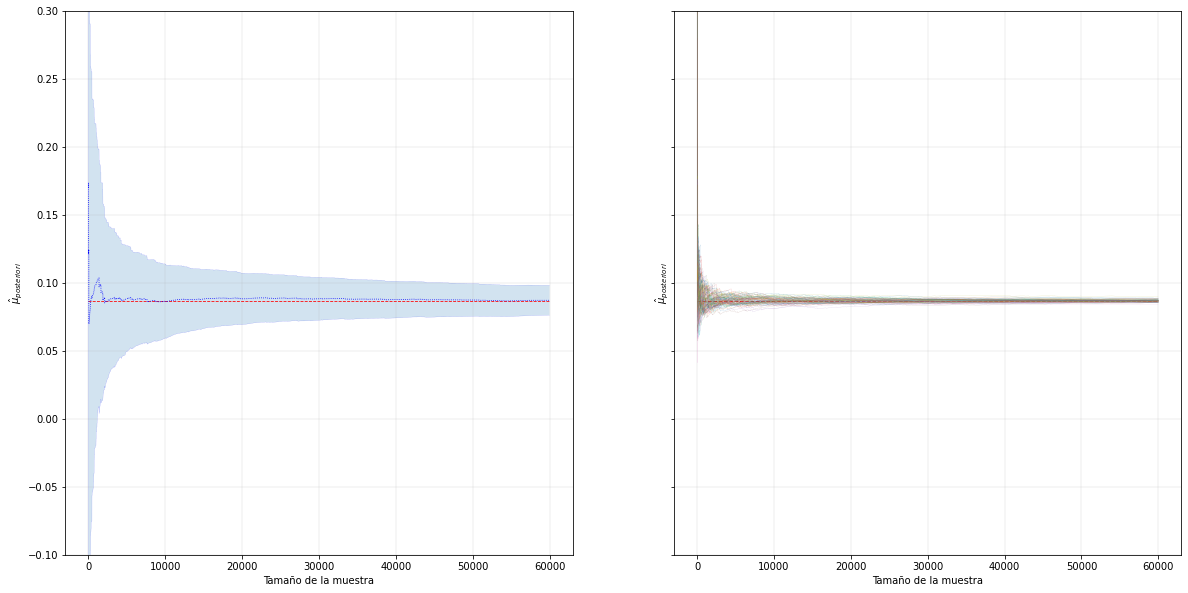

In [ ]:
plot_posteriori_where(max_sample_value=60000, significance_level=0.05, generator_beta=True)

Por tanto, utilizando muestras de 60000 y un nivel de significancia igual al $5\%$, el valor esperado de $\mu_{posterior}$ caerá dentro de [0.05262239084730649, 0.12192168249995364] el $95\%$ de las veces.


* **Supón que no se dispone de un generador de números aleatorios
para la distribución a priori (porqué o bien no dispones de un
algoritmo o este es muy ineficaz) ¿Podrías estimar
$\mu_{posterior}$? Estima el valor de $\mu_{posterior}$
sin utilizar el generador de una muestra de Beta (por
ejemplo utiliza una distribución $\mathcal{U}(0,1)$). Discute
el intervalo de confianza de la estimación.**

En este caso se deben agrupar los términos de la integral del siguiente modo:

$$\mu_{posterior} = \frac{ \int_{0}^{1} \; [\;\theta^{k+1} (1-\theta)^{n-k}
\; B(\theta | \alpha=5, \beta=10) \;]·1\; d \theta } {
\int_{0}^{1} [\;\theta^{k} (1-\theta)^{n-k} \; B(\theta | \alpha=5,
\beta=10) \; \;] ·1\; d \theta } $$ 

El $1$ corresponde a la distribución uniforme $\mathcal{U}(0,1)$ y las muestras $\{u_0, u_1, u_2, \cdots, u_n\}$ se evaluan en la función entre corchete, resultando la siguiente expresión (el intervalo de confianza se calcula de forma similar a lo hecho en el apartado anterior)

$$\widehat{\mu}_{posterior} = \frac{\widehat{I_1}}{\widehat{I_2}} = \frac{\sum{u_i^{k+1} (1-u_i)^{n-k}B(u_i | \alpha=5, \beta=10)}}{\sum{u_i^{k} (1-u_i)^{n-k}B(u_i | \alpha=5, \beta=10)}} = \frac{\sum{H_1({u_i})}}{\sum{H_2({u_i})}}$$

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08806391274474888 +- 0.00869394258095899
Nivel de significancia estadística: 0.22
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 6000


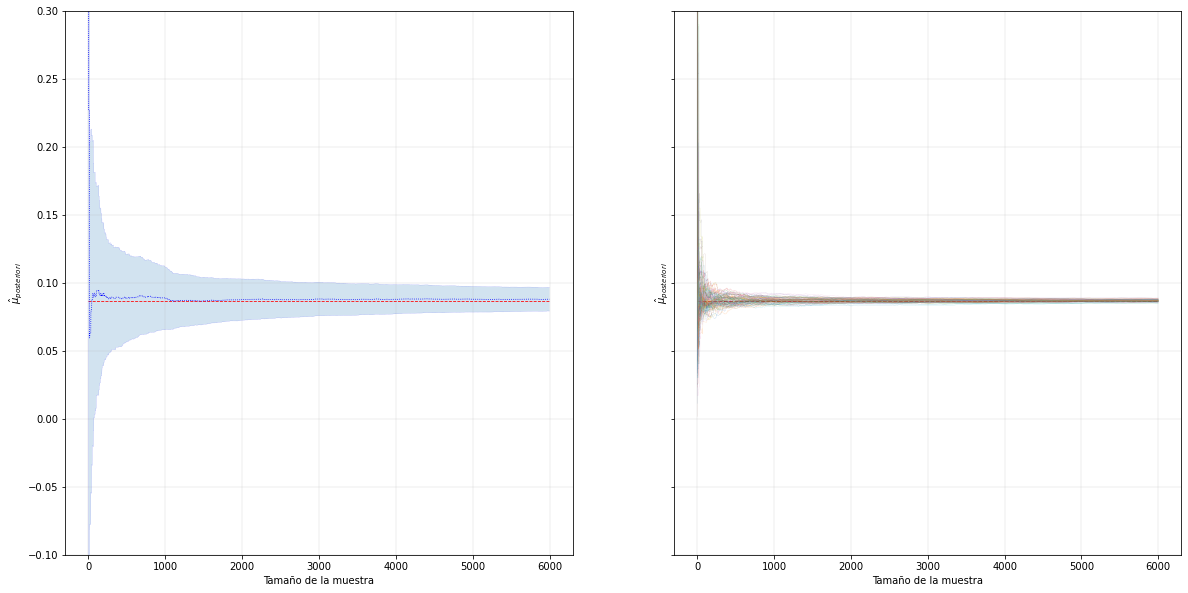

In [ ]:
plot_posteriori_where(max_sample_value=6000, significance_level=0.22, generator_beta=False)

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08755844741019757 +- 0.002758503850255876
Nivel de significancia estadística: 0.22
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 60000


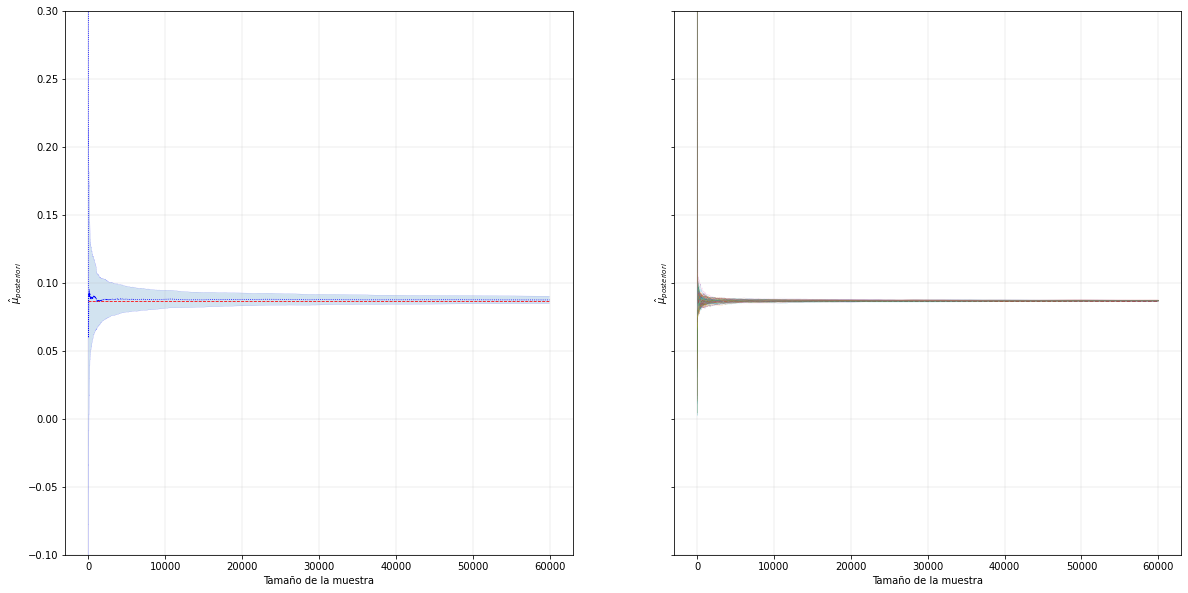

In [ ]:
plot_posteriori_where(max_sample_value=60000, significance_level=0.22, generator_beta=False)

Probabilidad a posteriori teórica esperada: 0.08695652173913043
Probabilidad a posteriori esperada: 0.08806391274474888 +- 0.01389272211861739
Nivel de significancia estadística: 0.05
Experimento: 
 Total pacientes: 100 	 UCI: 5
Tamaño máximo de la muestra = 6000


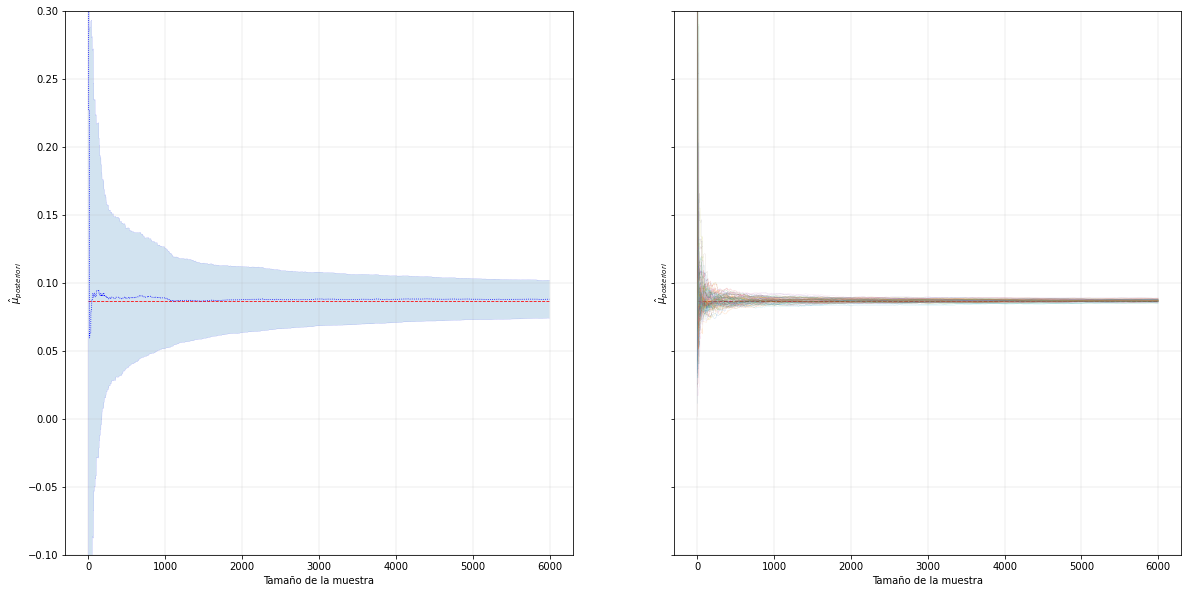

In [ ]:
plot_posteriori_where(max_sample_value=6000, significance_level=0.05, generator_beta=False)

Si observamos las gráficas de los intervalos de confianza vemos que presentan una varianza menor, cuando $N$ aumenta. Y que dicha varianza aumenta cuando el nivel de significancia estadística pasa de 0.22 a 0.05.



    
  
    

# Ejercicio 2

Estimar empíricamente la función de densidad de
probabilidad a posteriori $\pi(\theta | x)$ del ejercicio
anterior y validarla con el resultado teórico. Discutir los resultados.

## Introducción

Si recuerdas en el ejercicio anterior estimamos, utilizando Monte Carlo,
el valor esperado de $\theta$ *a posteriori*, es decir, una vez
realizado el experimento. Recuerda que lo estimamos **sin** necesidad de
conocer la distribución a posteriori $\pi(\theta | x)$. Para ello
utilizamos el Teorema de Bayes. Además validamos nuestra estimación con
la solución analítica.

Ahora nos planteamos ¿es posible generar una muestra de la variable
aleatoria de la distribución *a posteriori* $\pi(\theta | x)$?.
Para ello se propone utilizar un método de aceptación y rechazo y
validarlo con la solución analítica.

## Ayuda

El algoritmo consistirá en generar una muestra \$\\{\\theta_0,
\\theta_1, \\theta_2, \\cdots, \\theta_n\\}\$ de la distribución *a
priori* \$\\pi(\\theta)\$ y aceptar como valores de la distribución *a
psoteriori* \$\\pi(\\theta \| x)\$ aquellos \$\\theta_i\$ que satisfagan
un determinado criterio de aceptación/rechazo.

-   Un algoritmo y criterio *tentativo* podría ser:

> 1.  Generar una muestra \$\\{\\theta_0, \\theta_1, \\theta_2, \\cdots,
>     \\theta_n\\}\$ de la distribución a priori \$\\pi(\\theta)\$
> 2.  Aceptar \$\\theta_i\$ con probabilidad \$\$ p = \\frac{
>     \\pi(\\theta_i \| x) }{c \\cdot \\pi(\\theta_i) } \$\$ donde \$c\$
>     es, como de costumbre, una constante tal que para todo
>     \$\\theta\$, \$p \\in \[0, 1\]\$. Para aplicar el criterio
>     anterior podríamos generar una muestra \$\\{u_0, u_1, u_2,
>     \\cdots, u_n\\}\$ de la distribución uniforme \$U(0,1)\$ y aceptar
>     \$\\theta_i\$ si \$u_i \< \\frac{ \\pi(\\theta_i \| x) }{c \\cdot
>     \\pi(\\theta_i) }\$

Es decir, tratamos de aplicar el mismo algoritmo de aceptación/rechazo
visto en clase. El problema con este *criterio tentativo* es evidente.
Para aplicarlo necesitamos: (i) evaluar \$\\pi(\\theta \| x)\$ en
\$\\theta_i\$ y (ii) calcular previamente el valor de la constante
\$c\$. Pero ¿Cómo podemos hacerlo si precisamente desconocemos la
distribución \$\\pi(\\theta \| x)\$?¿Qúe podemos hacer? Recurrir al
Teorema de Bayes

-   Deducción del criterio de aceptación / rechazo. Por el teorema de
    Bayes sabemos  
    \$\$ \\frac{ \\pi(\\theta \| x) }{ \\pi(\\theta) } = \\frac{ \\pi(x
    \| \\theta) } { \\int\_{-\\infty}^{\\infty} \\pi(x \| \\theta)
    \\pi(\\theta) \\; d\\theta} \$\$

    pero, en vez de utilizar el lado izquierdo de la ecuación anterior
    para evaluar la probabilidad \$p\$ de aceptar \$\\theta_i\$ como en
    la ecuación (21), utilizaremos el miembro derecho de (22). Sin
    embargo, aun nos falta estimar el valor de \$c\$. Necesitamos
    *normalizar* el cociente \$\\frac{ \\pi(x \| \\theta) } {
    \\int\_{-\\infty}^{\\infty} \\pi(x \| \\theta) \\pi(\\theta) \\;
    d\\theta} \$ por una constante \$c\$ para que su valor este
    comprendido en el intervalo \$\[0, 1\]\$. Pero esto no es
    complicado. Sabemos que *necesariamente* \$\\frac{ \\pi(x \|
    \\theta) } { \\int\_{-\\infty}^{\\infty} \\pi(x \| \\theta)
    \\pi(\\theta) \\; d\\theta} \$ está acotado: el numerador es una
    función densidad de probabilidad y el denominador es una constante,
    no depende de \$\\theta\$. Es decir que \$\$ \\frac{ \\pi(x \|
    \\theta) } { \\int\_{-\\infty}^{\\infty} \\pi(x \| \\theta)
    \\pi(\\theta) \\; d\\theta} \\leq \\frac{ \\text{argmax}\_{\\theta}
    \\left( \\pi(x \| \\theta) \\right) } { \\int\_{-\\infty}^{\\infty}
    \\pi(x \| \\theta) \\pi(\\theta) \\; d\\theta} = c \$\$

    donde \$\\text{argmax}\_{\\theta} \\left( \\pi(x \| \\theta)
    \\right)\$ representa al valor máximo de la verosimilitud \$\\pi(x
    \| \\theta)\$. Es decir, ni siquiera necesitamos calcular la
    integral \$\\int\_{-\\infty}^{\\infty} \\pi(x \| \\theta)
    \\pi(\\theta) \\; d\\theta\$ ya que cuando dividamos la
    ecuación (22) por \$c\$ se nos va a cancelar!!!

Además sabemos que la función de verosimilitud alcanza su máximo cuando
\$\\theta \$ es el *valor máximo de verosimilitud* \$\\theta\_{MLE} =
k/N\$, siendo \$N\$ el número total de pacientes y \$k\$ el número de
pacientes que ingresan en la UCI. Recopilando todo:

-   Algoritmo final para obtener una muestra de \$\\pi(\\theta \|
    x)\$ \>

    > 1.  Calcular \$a = \\text{argmax}\_{\\theta} \\left( \\pi(x \|
    >     \\theta) \\right) \$
    > 2.  Generar una muestra \$\\{\\theta_0, \\theta_1, \\theta_2,
    >     \\cdots, \\theta_n\\}\$ de la distribución a priori
    >     \$\\pi(\\theta)\$
    > 3.  Aceptar \$\\theta_i\$ con probabilidad \$\$ p = \\frac{ \\pi(x
    >     \| \\theta) } {c \\cdot \\int\_{-\\infty}^{\\infty} \\pi(x \|
    >     \\theta) \\pi(\\theta) \\; d\\theta} = \\frac{ \\pi(x \|
    >     \\theta) }{a} \$\$

### Resultados Simulación Monte Carlo

En la siguiente gráfica se muestra un histograma con la estimación
empírica de la función de densidad de probabilidad a posteriori
\$\\pi(\\theta \| x)\$ junto con el resultado teórico (en azul
distribución Beta de parámetros \$a\$ y \$b\$ conocidos).

Las conclussiones son similares a las explicadas en el enunciado:

-   ¿Por que es tan baja la tasa de eficiencia? La tasa de eficiencia es
    un reflejo del solapamiento entre la distribución a priori
    \$\\pi(\\theta)\$, la distribución de la que se muestrea, y la
    distribución a posteriori \$\\pi(\\theta\|x)\$. Cuanto mas alejada
    esté la primera de la segunda, mayor será el porcentaje de muetras
    rechazadas. Recordad que \$\\sigma^2 \\to 0\$ de la distribución a
    posteriori cuando \$N \\to \\infty\$

-   ¿Como mejorar la tasa de eficiencia? Es posible realizar un Monte
    Carlo evolutivo cuando el conocimiento del experimento se incorpora
    paulatinamente.

**Referencia**

Simulación, métodos y aplicaciones, 2 edición. D. Rios Insúa et al.
Ra-Ma Editorial (2008), p. 188

In [ ]:
def get_p_values(theta_samples: np.ndarray) -> np.ndarray:
  return theta_samples**amount_of_successes*(1-theta_samples)**(amount_of_patients-amount_of_successes)*amount_of_patients/amount_of_successes

In [ ]:
np.random.seed(SEED)
amount_of_successes, amount_of_patients = 1, 20
max_sample_value = 100000

THETA_swept = np.linspace(0, 1, max_sample_value)
posterior = beta(ALPHA+amount_of_successes, _BETA+(amount_of_patients-amount_of_successes)).pdf(x=THETA_swept)

theta_samples = beta.rvs(ALPHA, _BETA,size=max_sample_value)
p_values = get_p_values(theta_samples)

u = uniform.rvs(size=max_sample_value)
x_ok = theta_samples[u < p_values]

Eficiencia: 0.02452
KstestResult(statistic=0.018576926578721675, pvalue=0.3614559368051382)
Tamaño máximo de la muestra = 100000


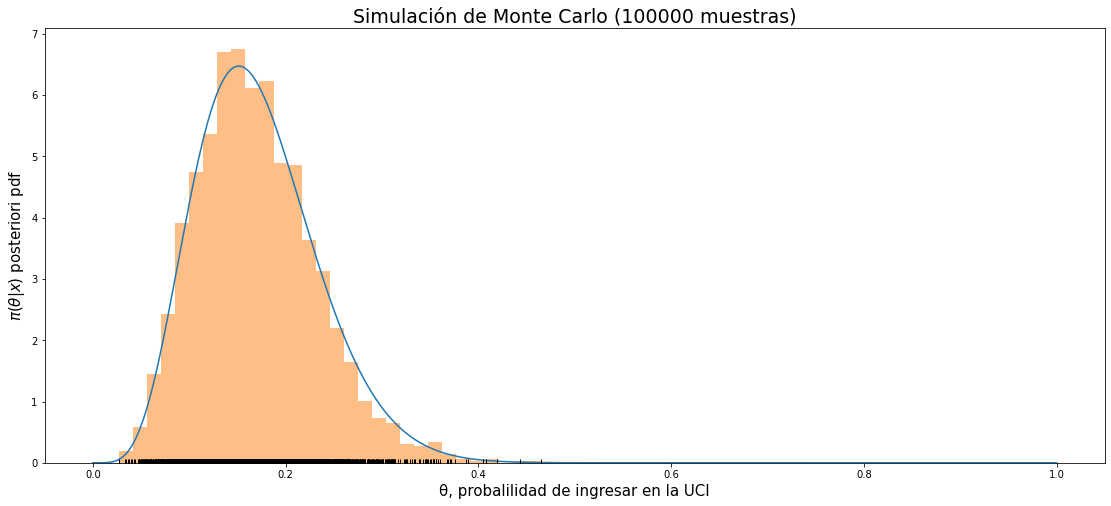

In [ ]:
print("Eficiencia: {}".format(len(x_ok) / max_sample_value))
print(kstest(x_ok, beta.cdf, args=(ALPHA+amount_of_successes, _BETA+(amount_of_patients-amount_of_successes))))
print("Tamaño máximo de la muestra = {}".format(max_sample_value))

plt.figure(figsize=(19,8))
plt.plot(THETA_swept, posterior)
plt.plot(x_ok, [0.01]*len(x_ok), '|', color='k')
plt.hist(x_ok,density=True, linewidth=1, bins=30,label='Sample',alpha=0.5)
plt.title('Simulación de Monte Carlo (%d muestras)' % max_sample_value,fontsize=19)
plt.xlabel('θ, probalilidad de ingresar en la UCI', fontsize=15)
plt.ylabel(r'$\pi(\theta|x)$ posteriori pdf', fontsize=15)
plt.show()

Con $100000$ muestras la eficiencia  es del $2.452\%$ y el $p$-valor con un test de Kolmogorov-Smirnov es $0.3614559368%$, al ser mayor que 0,05 no se puede rechazar la hipótesis nula $H_0$ de la distribución $B(a+k, b+(n-k))$.